In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer, models, InputExample, losses, evaluation
from sentence_transformers.util import SiameseDistanceMetric
import numpy as np
import random
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CONSTANTS = {
    "VOC_NAMES": ["Alpha", "Beta", "Delta", "Gamma", "Omicron"],
    "LOSS_NAME": "OnlineContrastiveLoss",
    "NEG_SET": "delta", # "other" or "delta"
    "POOLING_MODE": "max",
    "CONCAT": None, # "C" for concat-only, "CD" for concat+diff, or "CDM" for concat+diff+mult
    "NUM_LABELS": None,
    "CONF_THRESHOLD": None,
    "BATCH_SIZE": 32,
    "EPOCHS": 10,
    "LR": 1e-3,
    "RELU": 0.0,
    "DROPOUT": 0.0,
    "MARGIN": 1.0
}

In [2]:
#word_embedding_model = models.Transformer(model_name_or_path="Rostlab/prot_bert", max_seq_length=1280)

encoder = models.Transformer(model_name_or_path="./mlm_checkpoints/CoV-RoBERTa_2048",
                                          max_seq_length=1280,
                                          tokenizer_name_or_path="tok/")

dim = encoder.get_word_embedding_dimension() # 768

pooler = models.Pooling(dim, pooling_mode = CONSTANTS["POOLING_MODE"])

modules = [encoder, pooler]

if CONSTANTS["RELU"] > 0:
    dense = models.Dense(in_features=dim, out_features=int(dim*CONSTANTS["RELU"]), activation_function=nn.ReLU())
    modules.append(dense)

if CONSTANTS["DROPOUT"] > 0:
    dropout = models.Dropout(CONSTANTS["DROPOUT"])
    modules.append(dropout)

model = SentenceTransformer(modules=modules)

# # Freeze initial transformer layers
# for param in model[0].auto_model.embeddings.parameters():
#     param.requires_grad = False
# for param in model[0].auto_model.encoder.layer[:6].parameters():
#     param.requires_grad = False

print(model)

Some weights of the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at ./mlm_checkpoints/CoV-RoBERTa_2048 and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

SentenceTransformer(
  (0): Transformer({'max_seq_length': 1280, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': True, 'pooling_mode_global_max': False, 'pooling_mode_global_avg': False, 'pooling_mode_attention': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
)


# Generate Pairs for Training

In [3]:
omicron_sequences = pd.read_csv("data/unique_Omicron_2k.csv")["sequence"].tolist()
alpha_sequences = pd.read_csv("data/unique_Alpha_2k.csv")["sequence"].tolist()
beta_sequences = pd.read_csv("data/unique_Beta_2k.csv")["sequence"].tolist()
delta_sequences = pd.read_csv("data/unique_Delta_2k.csv")["sequence"].tolist()
gamma_sequences = pd.read_csv("data/unique_Gamma_2k.csv")["sequence"].tolist()

examples = []

if CONSTANTS["NEG_SET"] == "other":
    others = [alpha_sequences, beta_sequences, delta_sequences, gamma_sequences]
    for i, anc in enumerate(omicron_sequences):
        # get 4 random omicron sequences
        positives = random.sample(omicron_sequences, 4)
        for p, pos in enumerate(positives):
            neg = others[p][i]
            examples.append(InputExample(texts=[anc, pos], label=1))
            examples.append(InputExample(texts=[anc, neg], label=0))
elif CONSTANTS["NEG_SET"] == "delta":
    for i, anc in enumerate(omicron_sequences):
        # get 4 random omicron sequences
        positives = random.sample(omicron_sequences, 4)
        # get 4 random delta sequences
        negatives = random.sample(delta_sequences, 4)
        for pos, neg in zip(positives, negatives):
            examples.append(InputExample(texts=[anc, pos], label=1))
            examples.append(InputExample(texts=[anc, neg], label=0))

print("Training set length:", len(examples))

# split examples list into train, validation and test sets
random.shuffle(examples)
train_size = int(len(examples) * 0.8)
val_size = int(len(examples) * 0.1)
train_examples = examples[:train_size]
val_examples = examples[train_size:train_size + val_size]
test_examples = examples[train_size + val_size:]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=CONSTANTS["BATCH_SIZE"])
# val_dataloader = DataLoader(val_examples, shuffle=False, batch_size=CONSTANTS["BATCH_SIZE"])
# test_dataloader = DataLoader(test_examples, shuffle=False, batch_size=CONSTANTS["BATCH_SIZE"])

Training set length: 16000


# Generate Pairs for Zero-shot Test

In [4]:
o = pd.read_csv("data/unique_Omicron_2k.csv")["sequence"].tolist()
e = pd.read_csv("data/unique_Eris_2k.csv")["sequence"].tolist()[:2000]
n = pd.read_csv("data/unique_New_2k.csv")["sequence"].tolist()[:2000]

zero_test_examples = []

for i in range(len(omicron_sequences)):
        pos = n[i]
        neg = e[i]
        zero_test_examples.append(InputExample(texts=[anc, pos], label=1))
        zero_test_examples.append(InputExample(texts=[anc, neg], label=0))

print("Zero-shot test set length: ", len(zero_test_examples))

Zero-shot test set length:  4000


# Define Loss

In [5]:
if CONSTANTS["LOSS_NAME"] == "ContrastiveLoss":
    train_loss = losses.ContrastiveLoss(model=model,
                                        distance_metric=SiameseDistanceMetric.EUCLIDEAN,
                                        margin = CONSTANTS["MARGIN"])
elif CONSTANTS["LOSS_NAME"] == "OnlineContrastiveLoss":
    train_loss = losses.OnlineContrastiveLoss(model=model,
                                              distance_metric=SiameseDistanceMetric.EUCLIDEAN,
                                              margin = CONSTANTS["MARGIN"])

# Construct Evaluators

In [6]:
evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[val_example.texts[0] for val_example in val_examples],
    sentences2=[val_example.texts[1] for val_example in val_examples],
    labels=[val_example.label for val_example in val_examples],
    distance_metric=SiameseDistanceMetric.EUCLIDEAN,
    batch_size=CONSTANTS["BATCH_SIZE"],
    margin = CONSTANTS["MARGIN"],
    show_progress_bar=False,
    write_csv=True,
    name='Eval')

test_evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[test_example.texts[0] for test_example in test_examples],
    sentences2=[test_example.texts[1] for test_example in test_examples],
    labels=[test_example.label for test_example in test_examples],
    batch_size=CONSTANTS['BATCH_SIZE'],
    margin=CONSTANTS['MARGIN'],
    show_progress_bar=False,
    name="Test")

zero_test_evaluator = evaluation.BinaryClassificationEvaluator(
    sentences1=[zero_test_example.texts[0] for zero_test_example in zero_test_examples],
    sentences2=[zero_test_example.texts[1] for zero_test_example in zero_test_examples],
    labels=[zero_test_example.label for zero_test_example in zero_test_examples],
    batch_size=CONSTANTS['BATCH_SIZE'],
    margin=CONSTANTS['MARGIN'],
    show_progress_bar=False,
    name="Zero")

# Prepare Folders

In [7]:
import os
import shutil

# Create output directory if needed
output_dir = f"./outputs/{CONSTANTS['LOSS_NAME']}_omicron_vs_{CONSTANTS['NEG_SET']}_" \
                f"P{CONSTANTS['POOLING_MODE']}_" \
                f"R{CONSTANTS['RELU']}_" \
                f"D{CONSTANTS['DROPOUT']}_" \
                f"E{CONSTANTS['EPOCHS']}_" \
                f"LR_{CONSTANTS['LR']}_" \
                f"B{CONSTANTS['BATCH_SIZE']}_" \
                f"M{CONSTANTS['MARGIN']}"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
    print(f"Removed directory: {output_dir}")

checkpoint_dir = f"{output_dir}/checkpoints"
stats_dir = f"{output_dir}/stats"

for d in [checkpoint_dir, stats_dir]:
    if not os.path.exists(d):
        os.makedirs(d)
        print(f"Created directory: {d}")

Created directory: ./outputs/OnlineContrastiveLoss_omicron_vs_delta_Pmax_R0.0_D0.0_E10_LR_0.001_B32_M1.0/checkpoints
Created directory: ./outputs/OnlineContrastiveLoss_omicron_vs_delta_Pmax_R0.0_D0.0_E10_LR_0.001_B32_M1.0/stats


# Run Training & Test

In [8]:
# print CONSTANTS
for k, v in CONSTANTS.items():
    print(f"{k}: {v}")

model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          tester=test_evaluator,
          zero_shot_tester=zero_test_evaluator,
          epochs=CONSTANTS['EPOCHS'],
          optimizer_class=torch.optim.AdamW,
          optimizer_params= {'lr': CONSTANTS['LR']}, # 1e-3 for CoV-RoBERTa, 1e-6 for ProtBERT
          weight_decay=0.1, # 0.1 for CoV-RoBERTa, 0.01 for ProtBERT
          # evaluation_steps=64,
          output_path=output_dir,
          save_best_model=True,
          #checkpoint_path=checkpoint_dir,
          #checkpoint_save_steps=len(train_dataloader),
          #checkpoint_save_total_limit=1000000,
          show_progress_bar=True,
          loss_name=CONSTANTS['LOSS_NAME'])

VOC_NAMES: ['Alpha', 'Beta', 'Delta', 'Gamma', 'Omicron']
LOSS_NAME: OnlineContrastiveLoss
NEG_SET: delta
POOLING_MODE: max
CONCAT: None
NUM_LABELS: None
CONF_THRESHOLD: None
BATCH_SIZE: 32
EPOCHS: 10
LR: 0.001
RELU: 0.0
DROPOUT: 0.0
MARGIN: 1.0


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 0 ---
Train Loss = 3.6170   Train Accuracy = 0.7188
Eval Loss  = 0.2254   Eval Accuracy  = 0.5312    (using best distance threshold   = 0.0366)
Eval Loss  = 0.2254   Eval Accuracy  = 0.5062    (using median distance threshold = 0.0255)
Test Loss  = 0.2312   Test Accuracy  = 0.5350    (using best distance threshold   = 0.0323)
Test Loss  = 0.2312   Test Accuracy  = 0.5212    (using median distance threshold = 0.0256)
Zero Loss  = 0.2331   Zero Accuracy  = 0.8510    (using best distance threshold   = 0.0308)
Zero Loss  = 0.2331   Zero Accuracy  = 0.7905    (using median distance threshold = 0.0324)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 1 ---
Train Loss = 4.8436   Train Accuracy = 0.5000
Eval Loss  = 0.2329   Eval Accuracy  = 0.5619    (using best distance threshold   = 0.0112)
Eval Loss  = 0.2329   Eval Accuracy  = 0.5363    (using median distance threshold = 0.0093)
Test Loss  = 0.2390   Test Accuracy  = 0.5650    (using best distance threshold   = 0.0100)
Test Loss  = 0.2390   Test Accuracy  = 0.5587    (using median distance threshold = 0.0094)
Zero Loss  = 0.2439   Zero Accuracy  = 0.8662    (using best distance threshold   = 0.0109)
Zero Loss  = 0.2439   Zero Accuracy  = 0.8045    (using median distance threshold = 0.0114)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 2 ---
Train Loss = 4.6368   Train Accuracy = 0.5625
Eval Loss  = 0.2346   Eval Accuracy  = 0.5569    (using best distance threshold   = 0.0065)
Eval Loss  = 0.2346   Eval Accuracy  = 0.5400    (using median distance threshold = 0.0057)
Test Loss  = 0.2407   Test Accuracy  = 0.5656    (using best distance threshold   = 0.0057)
Test Loss  = 0.2407   Test Accuracy  = 0.5613    (using median distance threshold = 0.0058)
Zero Loss  = 0.2463   Zero Accuracy  = 0.8373    (using best distance threshold   = 0.0066)
Zero Loss  = 0.2463   Zero Accuracy  = 0.7835    (using median distance threshold = 0.0070)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 3 ---
Train Loss = 4.2173   Train Accuracy = 0.6250
Eval Loss  = 0.2360   Eval Accuracy  = 0.5450    (using best distance threshold   = 0.0039)
Eval Loss  = 0.2360   Eval Accuracy  = 0.5375    (using median distance threshold = 0.0027)
Test Loss  = 0.2423   Test Accuracy  = 0.5519    (using best distance threshold   = 0.0022)
Test Loss  = 0.2423   Test Accuracy  = 0.5413    (using median distance threshold = 0.0027)
Zero Loss  = 0.2482   Zero Accuracy  = 0.8040    (using best distance threshold   = 0.0032)
Zero Loss  = 0.2482   Zero Accuracy  = 0.7515    (using median distance threshold = 0.0034)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 4 ---
Train Loss = 5.0215   Train Accuracy = 0.6875
Eval Loss  = 0.2364   Eval Accuracy  = 0.5331    (using best distance threshold   = 0.0045)
Eval Loss  = 0.2364   Eval Accuracy  = 0.5112    (using median distance threshold = 0.0020)
Test Loss  = 0.2426   Test Accuracy  = 0.5175    (using best distance threshold   = 0.0057)
Test Loss  = 0.2426   Test Accuracy  = 0.5012    (using median distance threshold = 0.0020)
Zero Loss  = 0.2483   Zero Accuracy  = 0.8183    (using best distance threshold   = 0.0029)
Zero Loss  = 0.2483   Zero Accuracy  = 0.7635    (using median distance threshold = 0.0032)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 5 ---
Train Loss = 3.8738   Train Accuracy = 0.6250
Eval Loss  = 0.2375   Eval Accuracy  = 0.5531    (using best distance threshold   = 0.0000)
Eval Loss  = 0.2375   Eval Accuracy  = 0.5487    (using median distance threshold = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.6262    (using best distance threshold   = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.5988    (using median distance threshold = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.5460    (using best distance threshold   = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.5005    (using median distance threshold = 0.0000)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 6 ---
Train Loss = 4.3243   Train Accuracy = 0.5938
Eval Loss  = 0.2375   Eval Accuracy  = 0.5563    (using best distance threshold   = 0.0000)
Eval Loss  = 0.2375   Eval Accuracy  = 0.5463    (using median distance threshold = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.6294    (using best distance threshold   = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.6125    (using median distance threshold = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.5357    (using best distance threshold   = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.4980    (using median distance threshold = 0.0000)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 7 ---
Train Loss = 4.0616   Train Accuracy = 0.5625
Eval Loss  = 0.2375   Eval Accuracy  = 0.5500    (using best distance threshold   = 0.0000)
Eval Loss  = 0.2375   Eval Accuracy  = 0.5463    (using median distance threshold = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.6125    (using best distance threshold   = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.5913    (using median distance threshold = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.5380    (using best distance threshold   = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.5215    (using median distance threshold = 0.0000)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 8 ---
Train Loss = 3.4299   Train Accuracy = 0.6875
Eval Loss  = 0.2375   Eval Accuracy  = 0.5487    (using best distance threshold   = 0.0000)
Eval Loss  = 0.2375   Eval Accuracy  = 0.5437    (using median distance threshold = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.6062    (using best distance threshold   = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.5675    (using median distance threshold = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.5323    (using best distance threshold   = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.5275    (using median distance threshold = 0.0000)


Iteration:   0%|          | 0/400 [00:00<?, ?it/s]

--- Epoch 9 ---
Train Loss = 4.4939   Train Accuracy = 0.5625
Eval Loss  = 0.2375   Eval Accuracy  = 0.5513    (using best distance threshold   = 0.0000)
Eval Loss  = 0.2375   Eval Accuracy  = 0.5450    (using median distance threshold = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.6269    (using best distance threshold   = 0.0000)
Test Loss  = 0.2437   Test Accuracy  = 0.6050    (using median distance threshold = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.5460    (using best distance threshold   = 0.0000)
Zero Loss  = 0.2500   Zero Accuracy  = 0.4985    (using median distance threshold = 0.0000)


# Display Stats

In [9]:
# read loss values from csv:
f_train_stats = os.path.join(stats_dir, 'Train.csv')
f_eval_stats = os.path.join(stats_dir, 'Eval.csv')
f_test_stats = os.path.join(stats_dir, 'Test.csv')
f_zero_stats = os.path.join(stats_dir, 'Zero.csv')

train_stats = pd.read_csv(f_train_stats)
eval_stats = pd.read_csv(f_eval_stats)
test_stats = pd.read_csv(f_test_stats)
zero_stats = pd.read_csv(f_zero_stats)

best_test_acc = test_stats["accuracy"].max()
best_zero_acc = zero_stats["accuracy"].max()

# create a dataframe with CONSTANTS and best accuracies
df = pd.DataFrame()
for k, v in CONSTANTS.items():
    if k not in ["VOC_NAMES"]:
        df[k] = [v] # if v is not None else ["N/A"]

df["MAX_TEST_ACC"] = best_test_acc
df["MAX_ZERO_ACC"] = best_zero_acc

display(df)

# save the dataframe to a csv file under stats_dir
df.to_csv(os.path.join(stats_dir, "summary.csv"), index=False)

# append row to global_stats.csv
if not os.path.exists("global_stats.csv") or os.path.getsize("global_stats.csv") == 0:
    df.to_csv("global_stats.csv", index=False)
else:
    global_stats = pd.read_csv("global_stats.csv")
    global_stats = pd.concat([global_stats, df], ignore_index=True)
    global_stats.to_csv("global_stats.csv", index=False)

,LOSS_NAME,NEG_SET,POOLING_MODE,CONCAT,NUM_LABELS,CONF_THRESHOLD,BATCH_SIZE,EPOCHS,LR,RELU,DROPOUT,MARGIN,MAX_TEST_ACC,MAX_ZERO_ACC
0,OnlineContrastiveLoss,delta,max,None,None,None,32,10,0.001,0.0,0.0,1.0,0.6294,0.8662


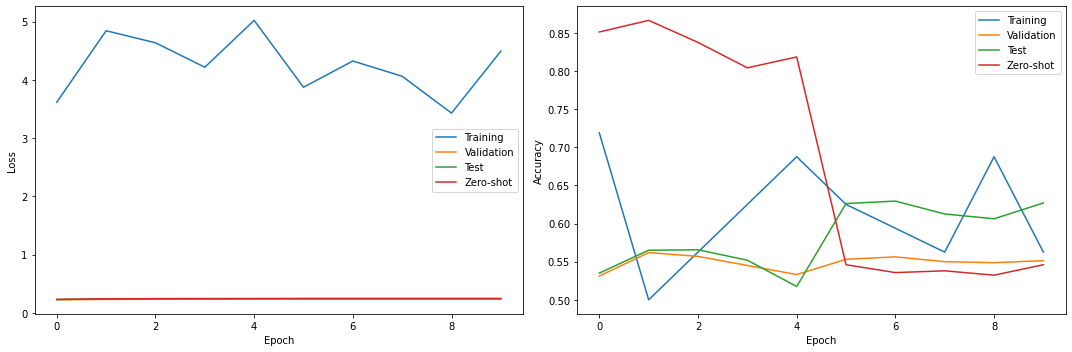

In [10]:
# Plot the training and validation loss and accuracy
import matplotlib.pyplot as plt

# plot loss and accuracy figures side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_stats["epoch"], train_stats["loss"], label="Training")
axs[0].plot(eval_stats["epoch"], eval_stats["loss"], label="Validation")
axs[0].plot(test_stats["epoch"], test_stats["loss"], label="Test")
axs[0].plot(zero_stats["epoch"], zero_stats["loss"], label="Zero-shot")

axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(train_stats["epoch"], train_stats["accuracy"], label="Training")
axs[1].plot(eval_stats["epoch"], eval_stats["accuracy"], label="Validation")
axs[1].plot(test_stats["epoch"], test_stats["accuracy"], label="Test")
axs[1].plot(zero_stats["epoch"], zero_stats["accuracy"], label="Zero-shot")

axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
plt.tight_layout()
#save as pdf
plt.savefig(os.path.join(stats_dir, "plot.pdf"))
plt.show()